In [25]:
import pandas as pd
from pathlib import Path
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_classification 
import numpy as np 
from matplotlib import pyplot as plt

In [78]:
'''create dataset of power usage estimates for each entry in trace dataset '''

power_curves = pd.read_csv("../processed/teads/instancelines.csv")
all_runs = pd.read_csv("../processed/scout/average_utils/averages.csv")
#print(power_curves.loc[["c4.2xlarge"]:])
#print(power_curves["cluster_type"])
power_curves = power_curves.set_index("cluster_type")
dfs=[]

for index, row in all_runs.iterrows():
    avgutil=row['avgcpu']
    instance=row['cluster_type']
    #print(row['cluster_type'],row['avgcpu'])
    hourpower=power_curves.loc[instance,'slope']* avgutil + power_curves.loc[instance,'intercept']
    powerused=(hourpower/3600)*row['elapsed_time']
    df = pd.DataFrame(data={'cluster_type' : row['name'],'power':powerused}, index=['cluster_type'])
    dfs.append(df)
all=pd.concat(dfs)
dfpath = Path(f"../processed/power.csv")
all.to_csv(dfpath, index=False)


In [83]:
PUE = 1.135
CARBON_INTENSITY = 228
power_estimates = pd.read_csv("../processed/power.csv")
dfs=[]
dfpath = Path(f"../processed/carbon.csv")
all.to_csv(dfpath, index=False)



In [14]:
print(float("hi"))

ValueError: could not convert string to float: 'hi'

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from collections import defaultdict
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn import preprocessing

'''New attempt at gradient boosting using all features'''

def train_gbr(df,target):


    # label
    y = df.pop(target)

    # drop runtime/util if not already - not sure if this is correct?
    #df.drop(columns=['avgcpu','elapsed_time'], inplace=True, errors='ignore')
    # feature vector
    name = df.pop("name")
    X = df
    unencoded_X=X.copy()
    # get columns containing text, apply label encoder and transform text to numbers
    cat_cols = X.select_dtypes(include='object').columns
    d = defaultdict(preprocessing.LabelEncoder)
    X[cat_cols] = X[cat_cols].apply(lambda x: d[x.name].fit_transform(x.astype(str)))

    # split dataset
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=0)

    # set regression model parameters to tweak later and see how results change
    params = {
        "n_estimators":500,
        "max_depth": 4,
        "min_samples_split": 5,
        "learning_rate": 0.01,
        "loss": "squared_error",
    }

    reg = GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)

    # attempt to make df of resultant data
    y_pred = reg.predict(X)
    results_features=pd.DataFrame(data={"true":y,"predicted":y_pred,"name":name})
    for col in unencoded_X.columns:
        if col in cat_cols:
            results_features[col] = (d[col].inverse_transform(X[col]))
        else:
            results_features[col]=X[col]
    dfpath = Path(f"../processed/gradboosttest_time_full.csv")
    results_features.to_csv(dfpath, index=False)
    
    mse = mean_squared_error(y_test, reg.predict(X_test))
    print(f'MSE = {round(mse,2)}')

    test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
    for i, y_pred in enumerate(reg.staged_predict(X_test)):
        test_score[i] = mean_squared_error(y_test, y_pred)

    fig = plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title("Deviance")
    plt.plot(
        np.arange(params["n_estimators"]) + 1,
        reg.train_score_,
        "b-",
        label="Training Set Deviance",
    )
    plt.plot(
        np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
    )
    plt.legend(loc="upper right")
    plt.xlabel("Boosting Iterations")
    plt.ylabel("Deviance")
    fig.tight_layout()
    plt.show()

    feature_importance = reg.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align="center")
    plt.yticks(pos, np.array(df.columns)[sorted_idx])
    plt.title("Feature Importance (MDI)")

    result = permutation_importance(
        reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()
    plt.subplot(1, 2, 2)
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=np.array(df.columns)[sorted_idx],
    )
    plt.title("Permutation Importance (test set)")
    fig.tight_layout()
    plt.show()

    

MSE = 35.41


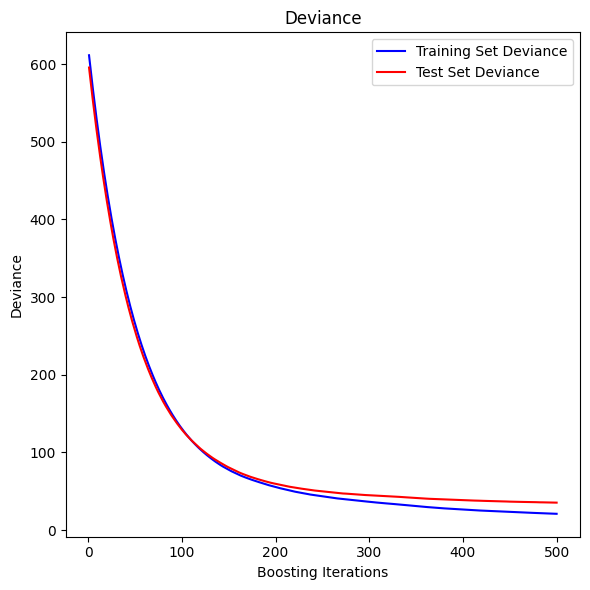

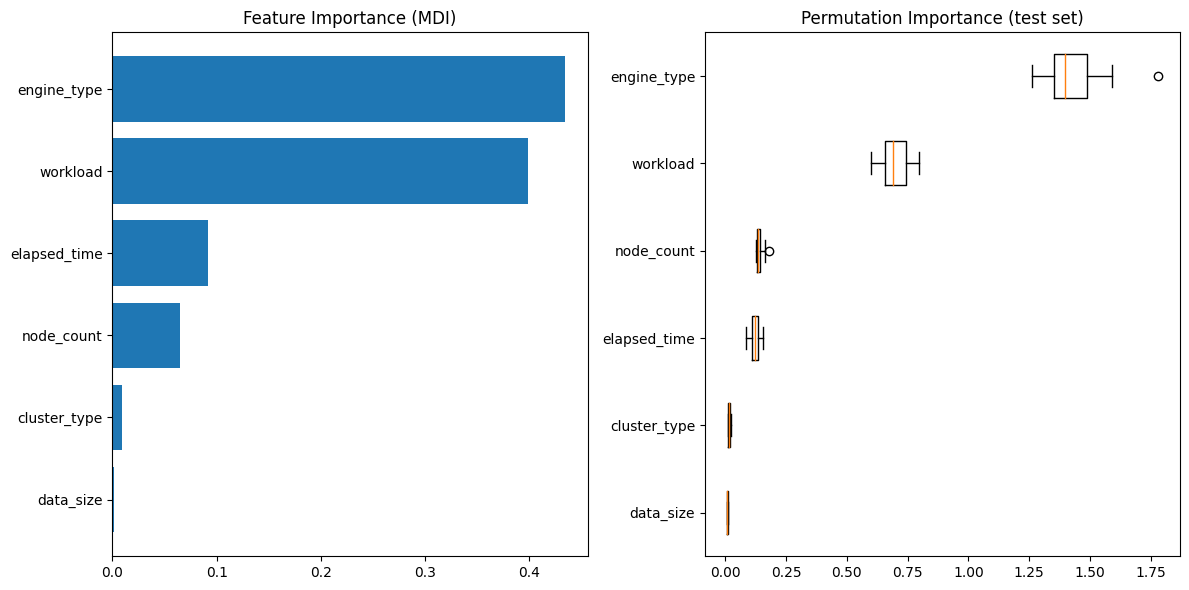

In [108]:
df = pd.read_csv("../processed/scout/average_utils/averages.csv")
train_gbr(df,target='avgcpu')

MSE = 627131.03


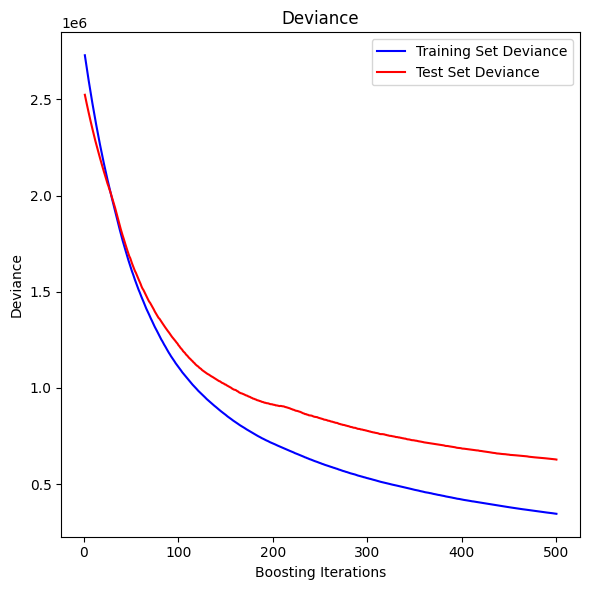

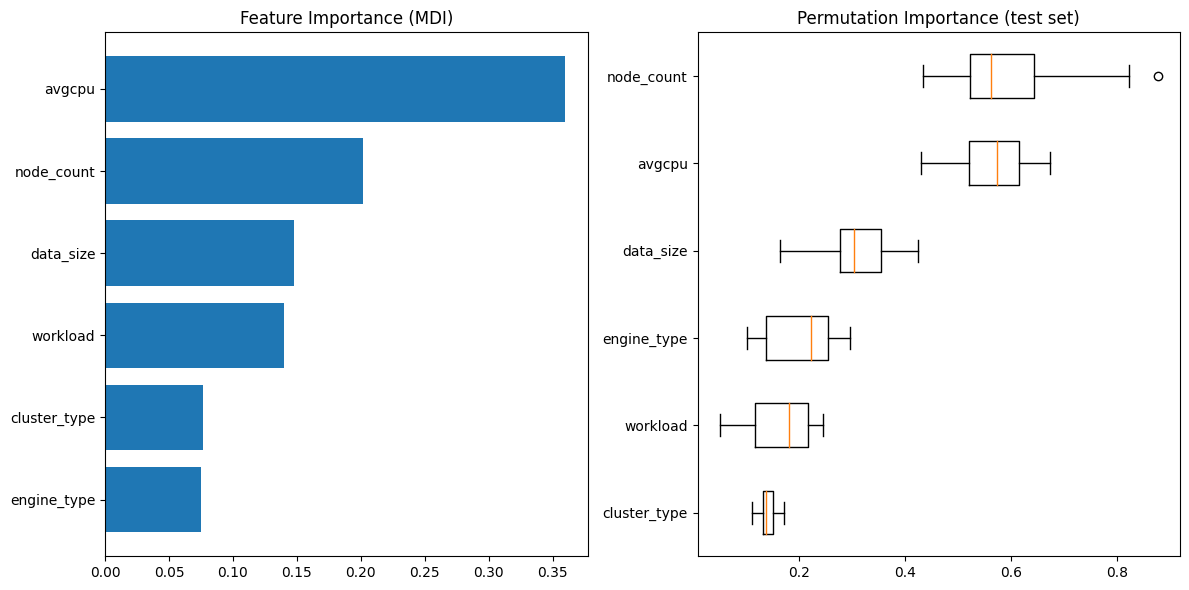

In [110]:
df = pd.read_csv("../processed/scout/average_utils/averages.csv")
train_gbr(df, target='elapsed_time')

In [37]:
'''old script to calculate node count interpolation using gbr'''

from scipy import stats 
import numpy as np 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
''' interpolate using node count with gradient boosting regression'''
def node_interpolation(df,nodecounts,jobs):
    dfs = []
    x=sorted(nodecounts)
    oneDx = np.array(x)
    x=oneDx.reshape(-1, 1)
    print(x)
    for j in jobs:
        filter_ = df['workload']==j
        y = (df[filter_].groupby(['node_count'])['avgcpu'].mean(numeric_only=True))
        #slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        #dfs.append(pd.DataFrame(data={'workload':[j],'slope':[slope],'intercept':[intercept],'error':[std_err],'r_value':[r_value],'p_value':[p_value],},index=[j]))
        gbr = GradientBoostingRegressor()
        gbr.fit(x, y)
        y_pred=gbr.predict(x)
        jarray=[j for i in range(len(y_pred))]
        dfs.append(pd.DataFrame(data={'noof_nodes':oneDx, 'job':j, 'predicted_util':y_pred},index=jarray))

        # attempting to use cross validation 
        '''
        loo = LeaveOneOut()
        loo.get_n_splits(x)
        # Use LOOCV to evaluate the model
        scores = []
        for train_index, test_index in loo.split(x):
            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y.values[train_index], y.values[test_index]
            gbr.fit(X_train, y_train)
            scores.append(gbr.score(X_test, y_test))

        '''
    #print(scores)
    all=pd.concat(dfs)
    return all

df = pd.read_csv("../processed/scout/average_utils/averages.csv")
nodecounts=df["node_count"].unique()
jobs=df["workload"].unique()

results = node_interpolation(df,nodecounts,jobs)
dfpath = Path(f"../processed/gradboosttest.csv")
results.to_csv(dfpath, index=False)
print(results)


[[ 4]
 [ 6]
 [ 8]
 [10]
 [12]
 [16]
 [20]
 [24]
 [32]
 [40]
 [48]]
           noof_nodes        job  predicted_util
join                4       join       71.204313
join                6       join       64.699194
join                8       join       58.049283
join               10       join       54.826318
join               12       join       48.734093
...               ...        ...             ...
wordcount          20  wordcount       49.314553
wordcount          24  wordcount       49.023703
wordcount          32  wordcount       45.724993
wordcount          40  wordcount       43.323302
wordcount          48  wordcount       45.209484

[88 rows x 3 columns]


In [91]:
def node_interpolation(df,nodecounts,jobs):
    dfs = pd.DataFrame()
    x=sorted(nodecounts)
    oneDx = np.array(x)
    x=oneDx.reshape(-1, 1)
    for j in jobs:
        filter_ = df['workload']==j
        y = (df[filter_].groupby(['node_count'])['avgcpu'].mean(numeric_only=True))
        #slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        #dfs.append(pd.DataFrame(data={'workload':[j],'slope':[slope],'intercept':[intercept],'error':[std_err],'r_value':[r_value],'p_value':[p_value],},index=[j]))
        gbr = GradientBoostingRegressor()
        gbr.fit(x, y)
        print(gbr.predict(99))
        dfs[j]=gbr
    return dfs

    
df = pd.read_csv("../processed/scout/average_utils/averages.csv")
nodecounts=df["node_count"].unique()
jobs=df["workload"].unique()
results = node_interpolation(df,nodecounts,jobs)

print(results)


ValueError: Expected 2D array, got scalar array instead:
array=99.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [124]:
# Playing around with .predict

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from collections import defaultdict
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn import preprocessing

df = pd.read_csv("../processed/scout/average_utils/averages.csv")
target='avgcpu'

# label
y = df.pop(target)

# drop runtime/util if not already - not sure if this is correct?
#df.drop(columns=['avgcpu','elapsed_time'], inplace=True, errors='ignore')
# feature vector
name = df.pop("name")
X = df
unencoded_X=X.copy()
# get columns containing text, apply label encoder and transform text to numbers
cat_cols = X.select_dtypes(include='object').columns
d = defaultdict(preprocessing.LabelEncoder)
X[cat_cols] = X[cat_cols].apply(lambda x: d[x.name].fit_transform(x.astype(str)))

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=0)

# set regression model parameters to tweak later and see how results change
params = {
    "n_estimators":500,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

reg = GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

# attempt to make df of resultant data
y_pred = reg.predict(X)
print(X.head(1))
print(reg.predict(X.head(1)))
print(reg.predict(np.array([48,0,0,1,0,305]).reshape(1, -1)))
results_features=pd.DataFrame(data={"true":y,"predicted":y_pred,"name":name})
for col in unencoded_X.columns:
    if col in cat_cols:
        results_features[col] = (d[col].inverse_transform(X[col]))
    else:
        results_features[col]=X[col]
dfpath = Path(f"../processed/gradboosttest_time_full.csv")
results_features.to_csv(dfpath, index=False)

mse = mean_squared_error(y_test, reg.predict(X_test))
print(f'MSE = {round(mse,2)}')




   node_count  cluster_type  workload  engine_type  data_size  elapsed_time
0          10             0         0            1          0       305.064
[49.12466288]
[27.73574868]
MSE = 35.41


c:\Users\crazy\OneDrive - University of Glasgow\_Fourth Year\Project\emissions-estimator\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
